
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
#!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud_2020
import gensim


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
#!pip install gensim
#!pip install cython
#import gensim #For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 
<200 words

I will look at the Marx-Engels Collected Works corpus, which is a set of historical texts from 1835-1885 authored by both Marx and Engels. The texts contains well known published works (ex. Marx's Capital) in additiona to obscure and unpublished works (including personal letters and poetry). I've scraped the text by paragraph, meaning each row in the data table is a single paragraph of the MECW. Other columns describe the nature of the volume ("Volume 35," corresponding to works from a certain year) and the sub-volume document from which the paragraph comes ("Chapter I: Commodities," "Letter from Marx to Engel," etc.).

## ***Why?***
<200 words

Marx's corpus is of interest both as a historical text/discourse and as an active site of contested meanings for various strains of Marxian and non-Marxian modern inheritors. The corpus is also the subject of vigorous debates, many involving famous social theorists and philosophers. For instance, Althusser argued that there was an epistemological break between Young Marx (early text) and Late Marx (mature texts,) with only the mature texts reflecting a true "science of history." This is far from the only debate. For instance, modern anthropologists argue over whether Marx maintained a unilinear or teleological conception of history. 

These are fundamentally hermeneutic questions, but they are also to some degree empirical questions. Thus, although it is perhaps borderline blasphemy to existing scholars, I propose that sensible empirical interventions into the text (i.e. language content analysis) can offer productive and persuasive evidence for interpretation.

## ***How?***
<400 words

First, I need to finish cleaning the text: there's complex artifacts from translators and the web hosting site to remove. Additionally, the data is inconsistently formulated and may contain near duplicates. Furthermore, especially in sections with poetry and formulas, the paragraph flow can be radically disrupted. We will see in this HW that this has large consequences for topic clustering, for instance.

Provisionally, I intend to do various forms of supervised word counting around hand-picked categories relevant to these debates, such as "value," "labour," and "history." To this I will supplement some of the linguistic structure and contexted we used in Week 3 HW. Additionally, I plan to supplement this with analysis from topic modeling - the distribution and change of topics over time in Marx's corpus. Finally, I think I will likely use a technique from one of the final 3 HW's - this remains to be seen but perhaps "Exploring Semantic Spaces." I don't yet know what that means exactly but excited to find out!

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***

Actually, I'm in a fairly favorable position for this analysis, having 1) successfully gathered the entire MECW corpus, and 2) chosen a hermeneutic question which is by nature confined to this corpus. Of course, a larger project could expand beyond Marx and look at changing rhetoric and ideas in the entire set of left-wing Marxist texts over time (ex. 1st International vs. 2nd, etc.) To be honest I may have to scale down by focus on the MECW because of the size of that corpus alone due to computational constriants, but right now I hope to be able to run my code over the whole dataset.

**Note on today's HW:** The entire MECW is nearly 400mb and quite ambitious to take on. In this HW I confine myself to a particular subsection of the MECW, namely Volume 35, which encompasses the entirely of Marx's Capital, Volume I (and nothing else.)

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [4]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [5]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [6]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [7]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again. 

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram). 

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [8]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [9]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [10]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [11]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [12]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms. 

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [13]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [14]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [15]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [16]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [17]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [18]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [19]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', 'mean_tweedie_deviance', 'median_absolute_error', 'mult

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [20]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3


We can also look at the distinguishing features in each cluster:

In [21]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 car
 cars
 engine
 like
 just
 good
 think
 dealer
 don
 new


Cluster 1:
 window
 server
 use
 motif
 using
 widget
 program
 application
 like
 code


Cluster 2:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 sell
 interested
 price


Cluster 3:
 know
 thanks
 mac
 just
 does
 drive
 apple
 like
 don
 problem




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [22]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [23]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [24]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

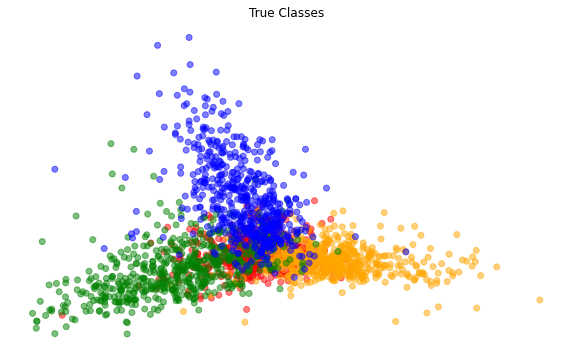

In [25]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

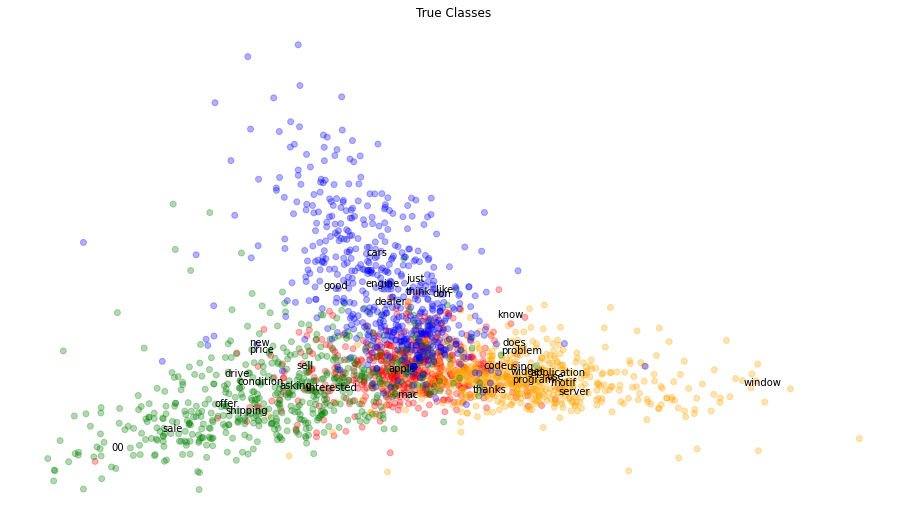

In [26]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [27]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

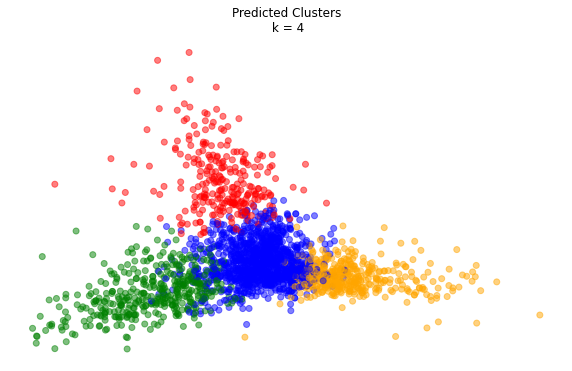

In [28]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [29]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [30]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors) 

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


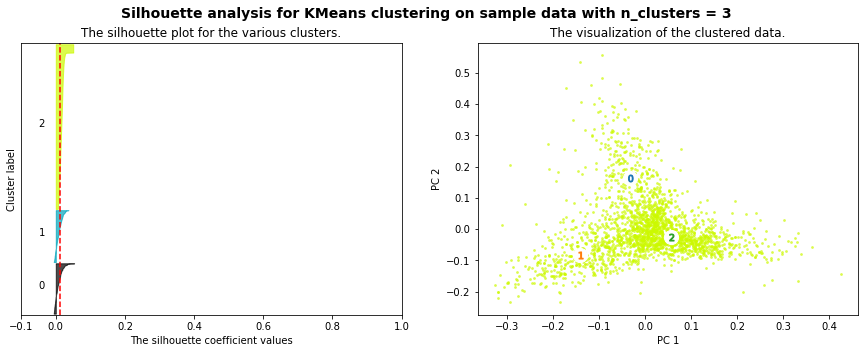

For n_clusters = 3, The average silhouette_score is : 0.013


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


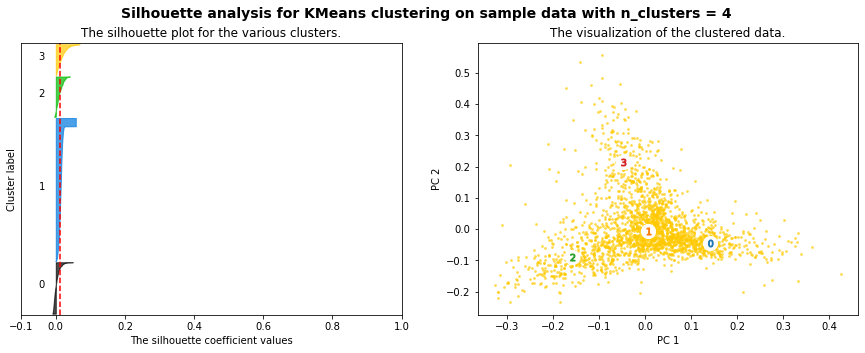

For n_clusters = 4, The average silhouette_score is : 0.012


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


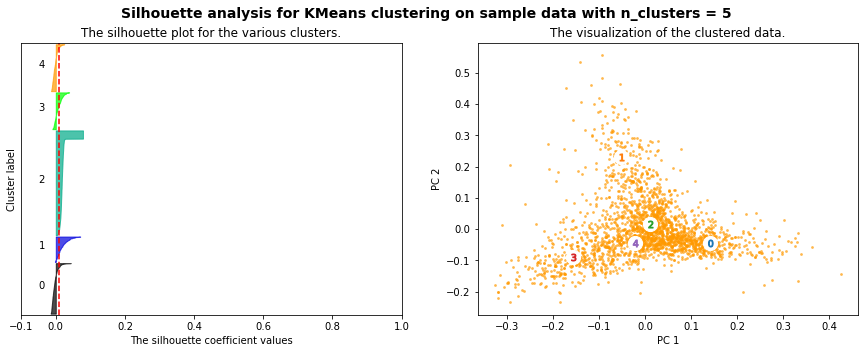

For n_clusters = 5, The average silhouette_score is : 0.010


In [33]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


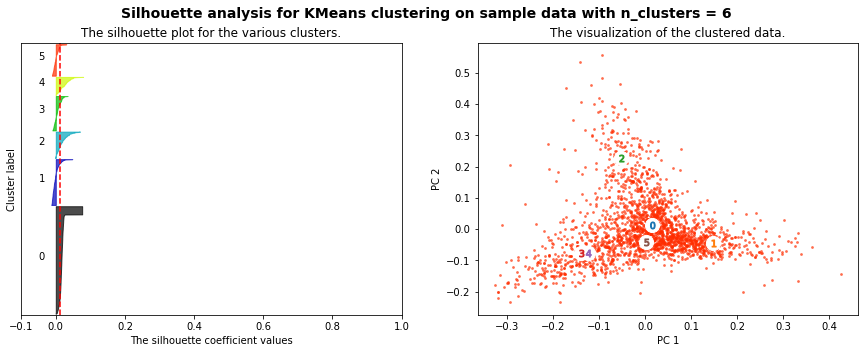

For n_clusters = 6, The average silhouette_score is : 0.012


In [34]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [35]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [36]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [37]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [38]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [39]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [40]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [41]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

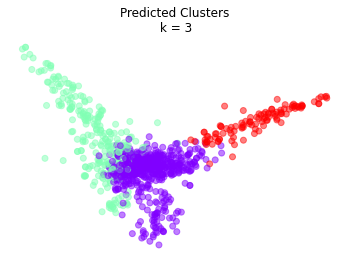

In [42]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [43]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,1
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,0
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [44]:
capital = pandas.read_csv(r'C:\Users\super\comp_work\Homework-Notebooks\votava_project_data\capital.csv')
capital_copy = capital

In [45]:
#initialize
capTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.4, max_features=2000, min_df=10, stop_words='english', norm='l2')
#train
capitalTFVects = capTFVectorizer.fit_transform(capital_copy['paragraph_text'])

capPCA = sklearn.decomposition.PCA
cappca = capPCA(n_components = 2).fit(capitalTFVects.toarray())
cap_reduced_data = cappca.transform(capitalTFVects.toarray())

def plotSilhouette(reduced_data,n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, max_iter=3000, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    
    ax2.scatter(cap_reduced_data[:, 0], cap_reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors) 

    # Labeling the clusters
    centers_c = clusterer.cluster_centers_
    projected_centers = cappca.transform(centers_c)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


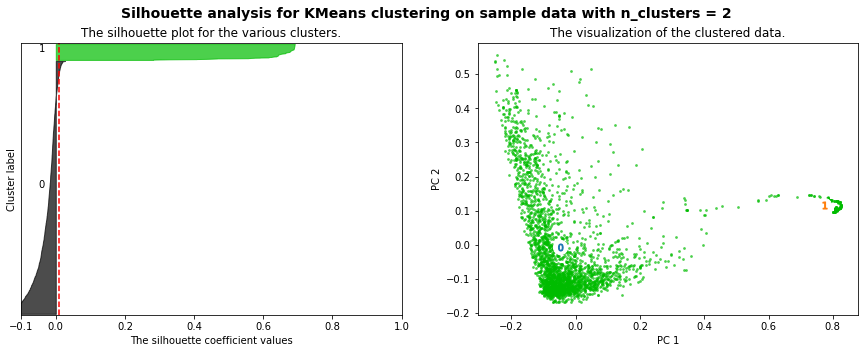

For n_clusters = 2, The average silhouette_score is : 0.010


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


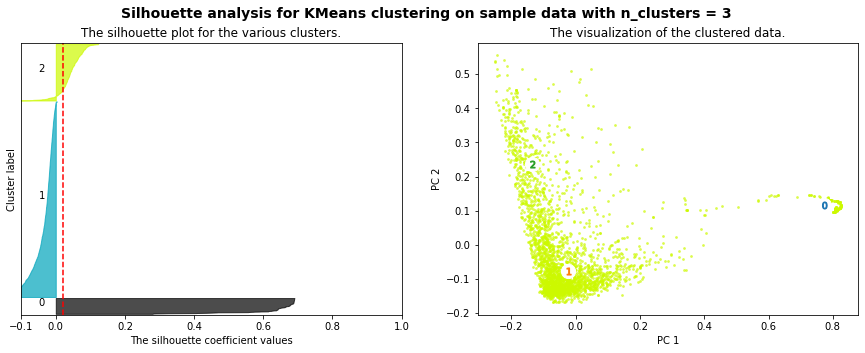

For n_clusters = 3, The average silhouette_score is : 0.020


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


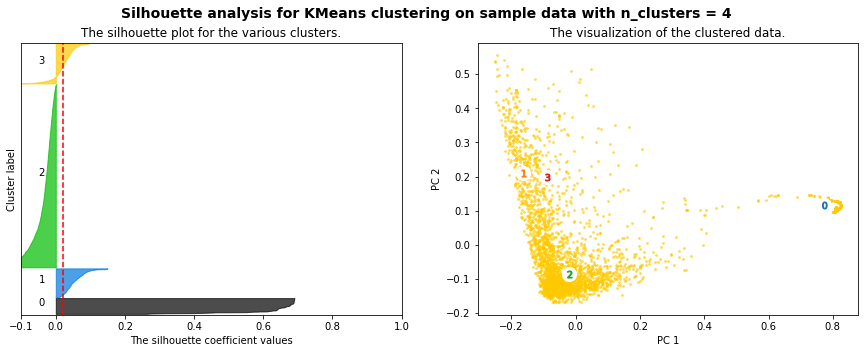

For n_clusters = 4, The average silhouette_score is : 0.020


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


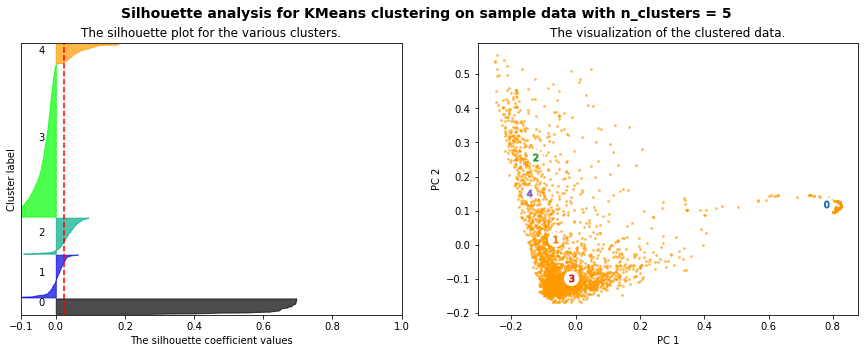

For n_clusters = 5, The average silhouette_score is : 0.024


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


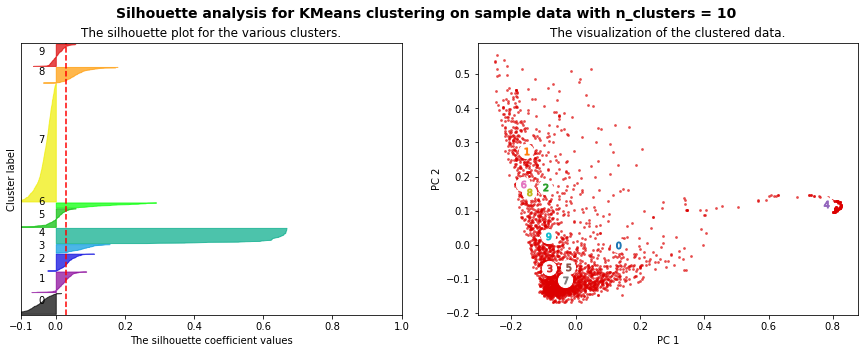

For n_clusters = 10, The average silhouette_score is : 0.030


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


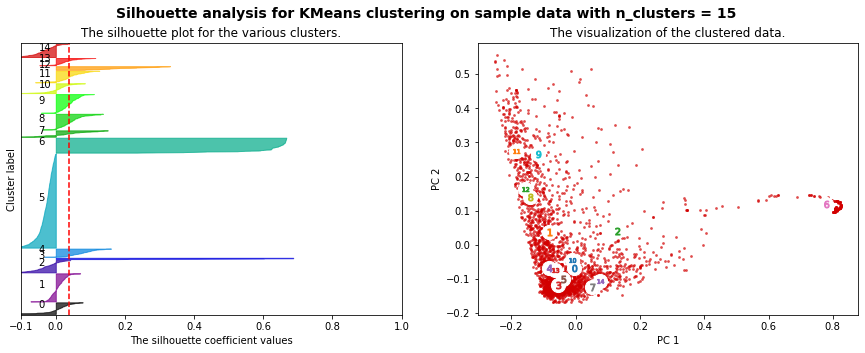

For n_clusters = 15, The average silhouette_score is : 0.039


In [46]:
X = capitalTFVects.toarray()
plotSilhouette(cap_reduced_data, 2, X)
plotSilhouette(cap_reduced_data, 3, X)
plotSilhouette(cap_reduced_data, 4, X)
plotSilhouette(cap_reduced_data, 5, X)
plotSilhouette(cap_reduced_data, 10, X)
plotSilhouette(cap_reduced_data, 15, X)

In [47]:
def compare_sil(max_n, X):
    x = []
    y = []
    for i in range(2,max_n):
        clusterer = sklearn.cluster.KMeans(n_clusters=i, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
        x.append(i)
        y.append(silhouette_avg)
    matplotlib.pyplot.plot(x,y)

**Comment:** Let's use this helper function to see how silhoutte scores change as we add topics. It's not immediately clear to me how many "natural" topics there should be, seeing as this corpus (even just Capital alone) is pretty large and contains a variety of organic topics within.

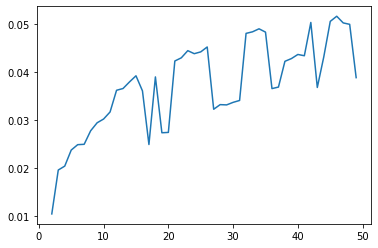

In [48]:
X = capitalTFVects.toarray()
compare_sil(50,X)

**Comment:** From the graph we can see a reasonable local maximum at n=16 clusters. For the rest of this exercise, I'll first look at n=3 clusters as a simple analysis, and n=16 clusters for a more fine-grained approach.

Top terms per cluster:
Cluster 0:
 reports
 hours
 31st
 time
 work
 day
 factory
 act
 october
 children


Cluster 1:
 value
 commodity
 money
 commodities
 form
 surplus
 production
 capital
 power
 product


Cluster 2:
 capital
 work
 production
 working
 time
 day
 capitalist
 factory
 labourer
 hours




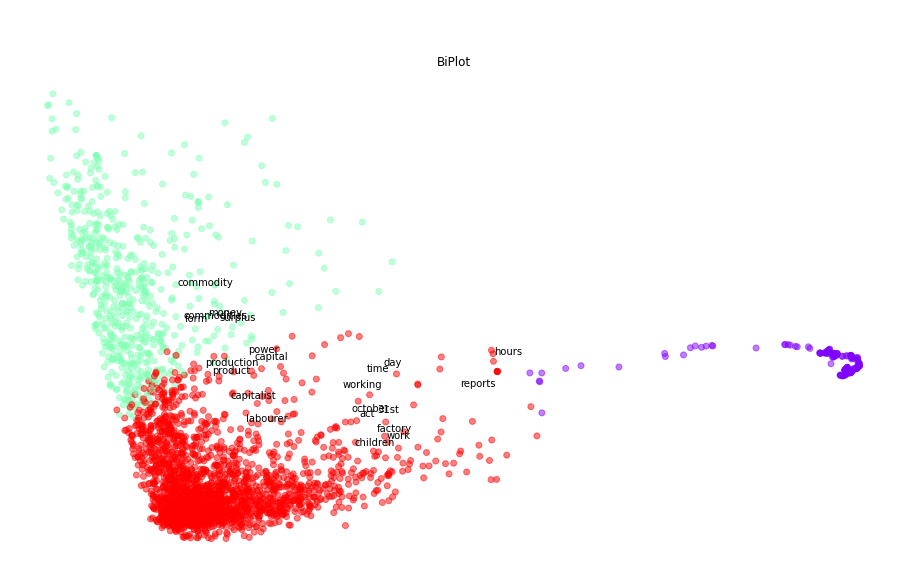

In [49]:
numCategories = 3

capitalKM3 = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
capitalKM3.fit(capitalTFVects)
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in capitalKM3.labels_]

terms = capTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = capitalKM3.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

components = cappca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]


fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(cap_reduced_data[:, 0], cap_reduced_data[:, 1], color = colors_p, alpha = 0.5, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('BiPlot')
plt.show()

In [50]:
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(capital_copy['link_name'], capitalKM3.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(capital_copy['link_name'], capitalKM3.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(capital_copy['link_name'], capitalKM3.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(capital_copy['link_name'], capitalKM3.labels_)))

Homogeneity: 0.110
Completeness: 0.438
V-measure: 0.176
Adjusted Rand Score: 0.063


Top terms per cluster:
Cluster 0:
 work
 factory
 says
 lond
 london
 pp
 man
 report
 trade
 time


Cluster 1:
 linen
 coat
 value
 yards
 20
 commodity
 form
 different
 commodities
 equivalent


Cluster 2:
 wages
 price
 piece
 labourer
 time
 work
 wage
 value
 working
 power


Cluster 3:
 markup
 html
 transcribed
 1999
 stephen
 baird
 zodiac
 index
 volume
 chapter


Cluster 4:
 capital
 production
 capitalist
 accumulation
 means
 process
 power
 value
 labourer
 surplus


Cluster 5:
 division
 machinery
 manufacture
 machine
 production
 machines
 industry
 operation
 modern
 factory


Cluster 6:
 rep
 fact
 31st
 insp
 empl
 comm
 pp
 ch
 oct
 1865


Cluster 7:
 reports
 hours
 31st
 time
 work
 day
 factory
 act
 october
 children


Cluster 8:
 value
 surplus
 power
 capital
 magnitude
 day
 rate
 variable
 relative
 capitalist


Cluster 9:
 money
 commodities
 circulation
 gold
 commodity
 silver
 value
 form
 prices
 values


Cluster 10:
 la
 et
 le
 les
 des
 il
 une
 que

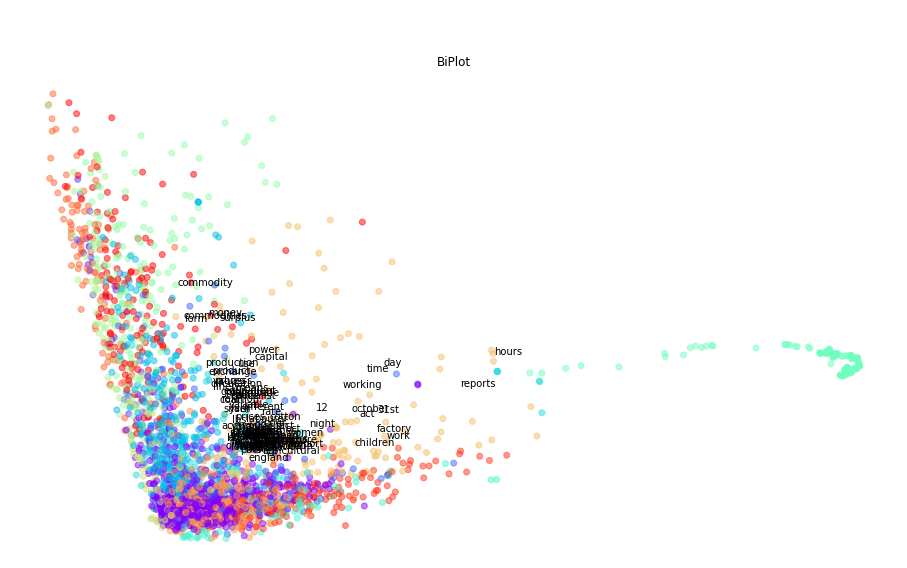

In [51]:
numCategories = 16

capitalKM16 = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
capitalKM16.fit(capitalTFVects)
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in capitalKM16.labels_]

terms = capTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = capitalKM16.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

components = cappca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]


fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(cap_reduced_data[:, 0], cap_reduced_data[:, 1], color = colors_p, alpha = 0.5, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('BiPlot')
plt.show()

In [52]:
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(capital_copy['link_name'], capitalKM16.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(capital_copy['link_name'], capitalKM16.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(capital_copy['link_name'], capitalKM16.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(capital_copy['link_name'], capitalKM16.labels_)))

Homogeneity: 0.307
Completeness: 0.364
V-measure: 0.333
Adjusted Rand Score: 0.127


**Comment:** Despite looking absolutely horrendous on the 2D graph, the groupings produced by the n=16 cluster actually have pretty good logical cohesion. Taking a stab at interpretation, I would assign clusters labels something like the following: (Aside, I realized after writing that the order in which the clusters displays changes every time you run the cell...)


0: English agriculture

1: English industrialization

2: labour power

3: factory labour

4: demography

5: capitalism as mode of production

6: wage

7: commodity money

8: abbreviations/formulas

9: surplus accumulation

10: labour history/factory history

11: industrial machinery

12: French text

13: exchange value

14: translation artifact (needs cleaning)

15: value form


This list isn't too bad, aside from idiosyncracies of the text (passages in French, passages from the translator, abbreviations and formulas messing things up. The three-topic approach is OK, too: 


0: capital and production

1: labour history (this is the weird sparse one that shows up as a kind of dangling tail on the plot)

2: commodities and value


The statistics from the k-means tests make decent sense too. In the three-topic model, each chapter - despite having relatively low homogeneity - has very low Rand score because most chapters include a weighted mix of all three topics. The 16 topic model does better here: lower completeness, higher v-measure, and higher adjusted Rand score.

In [53]:
capital_copy['kmeans3_predictions'] = capitalKM3.labels_
capital_copy['kmeans16_predictions'] = capitalKM16.labels_
capital_copy

,index,vol_source,vol_name,link_source,link_name,paragraph_text,kmeans3_predictions,kmeans16_predictions
0,2,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,Section 1 - The Two Factors of a Commodity: U...,1,13
1,3,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,A. Elementary or Accidental Form of Value,1,13
2,4,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,1. The Two Poles of the Expression of Value: ...,1,13
3,5,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,a. The Nature and Import of this Form b. Qua...,1,13
4,6,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,3. The Equivalent Form of Value 4. The Eleme...,1,13
...,...,...,...,...,...,...,...,...
2825,19,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch33.html,Chapter XXXIII The Modern Theory of Colonisation,"5. E. G. Wakefield: “England and America,” vol...",2,0
2826,24,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch33.html,Chapter XXXIII The Modern Theory of Colonisation,"10. “Land, to be an element of colonization, m...",2,12
2827,30,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch33.html,Chapter XXXIII The Modern Theory of Colonisation,"16. Merivale, l.c., Vol.II, pp.235-314 passim....",2,10
2828,34,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch33.html,Chapter XXXIII The Modern Theory of Colonisation,"20. “C’est, ajoutez-vous, grâce � l’appropriat...",2,10


# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [54]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [55]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [56]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


C:\Users\super\anaconda3\lib\site-packages\scipy\sparse\_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [57]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [58]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [59]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

C:\Users\super\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 76.        , 193.        ,   0.        ,   2.        ],
       [195.        , 200.        ,   0.        ,   3.        ],
       [198.        , 201.        ,   0.        ,   4.        ],
       [105.        , 202.        ,   0.37033177,   5.        ],
       [ 54.        , 169.        ,   0.40914841,   2.        ],
       [110.        , 144.        ,   0.44134524,   2.        ],
       [149.        , 162.        ,   0.45096656,   2.        ],
       [151.        , 204.        ,   0.4553535 ,   3.        ],
       [ 67.        , 206.        ,   0.4650683 ,   3.        ],
       [102.        , 146.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

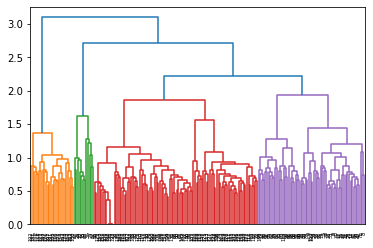

In [60]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

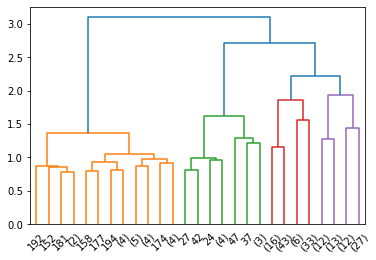

In [61]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [62]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4,
       3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4,
       4, 4, 4, 2, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
       4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [63]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [64]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,3,4
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [65]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

C:\Users\super\anaconda3\lib\site-packages\scipy\sparse\_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\super\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

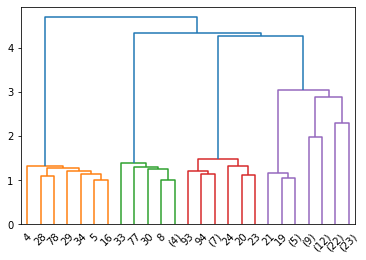

In [66]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [67]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

In [68]:
hierarchical_clusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 3, 'maxclust')
hierarchical_clusters

array([3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 3], dtype=int32)

In [69]:
hierarchical_clusters3 = scipy.cluster.hierarchy.fcluster(linkage_matrix, 16, 'maxclust')
hierarchical_clusters3

array([15, 15,  1, 15, 16, 15, 15,  4, 16, 14,  8, 15, 15, 11, 15, 15,  7,
       15,  3, 15, 15, 15,  8,  4,  3,  3, 15,  3, 15, 14,  8, 15,  4, 15,
       14, 14, 15,  5,  8,  3, 15, 15,  3, 14, 15, 15, 15,  6, 13,  8,  8,
       13, 12,  7,  8,  7,  7,  8,  8,  8,  8,  8, 11, 10, 11, 11, 13,  8,
        8, 14, 14, 16, 10, 12, 11, 11,  7,  3, 14, 15, 10, 13,  8, 11, 12,
       11, 13, 11, 14, 14,  8, 11,  8, 12, 13, 11, 13,  8, 10, 12,  7,  8,
       10,  9, 10,  7, 10,  8, 10, 10,  8, 10, 10, 10, 12,  8, 10,  8,  9,
       10,  9, 10, 10,  8, 10, 10, 10, 10, 10,  9,  7, 10,  8, 10,  9,  8,
        8, 10,  8, 10, 10, 10, 10, 10,  8, 10, 10, 10, 10,  8, 14,  8,  1,
        2,  2,  8,  7,  8,  2,  7,  8,  2,  8,  2,  8,  2,  2,  2,  8,  8,
        2,  1,  2,  7,  2,  2,  2,  2,  2,  8,  2,  1,  2,  8,  2,  8,  9,
        7, 11,  8,  8,  2,  1,  7,  2,  7,  7,  2,  7, 14], dtype=int32)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [70]:
capital_map = capitalTFVects * capitalTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
capital_map.setdiag(0)

In [71]:
selectIndices = []
indexToCat = []
for c in set(capital_copy['link_name']):
    selectIndices += list(capital_copy[capital_copy['link_name'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()
sub_mat = capital_map[selectIndices,:][:,selectIndices]
cap_linkage_matrix = scipy.cluster.hierarchy.ward(sub_mat.toarray())
cap_linkage_matrix[:10]

array([[7.61000000e+02, 8.97000000e+02, 6.76099488e-01, 2.00000000e+00],
       [1.15500000e+03, 1.22100000e+03, 7.17515016e-01, 3.00000000e+00],
       [1.11900000e+03, 1.22200000e+03, 7.35968469e-01, 4.00000000e+00],
       [8.13000000e+02, 1.22300000e+03, 7.69933673e-01, 5.00000000e+00],
       [3.53000000e+02, 8.11000000e+02, 8.01097135e-01, 2.00000000e+00],
       [8.80000000e+02, 9.00000000e+02, 8.17265060e-01, 2.00000000e+00],
       [3.47000000e+02, 4.43000000e+02, 8.37745055e-01, 2.00000000e+00],
       [7.31000000e+02, 1.22400000e+03, 9.21265629e-01, 6.00000000e+00],
       [4.27000000e+02, 8.15000000e+02, 9.46322054e-01, 2.00000000e+00],
       [1.22800000e+03, 1.22900000e+03, 9.56156590e-01, 8.00000000e+00]])

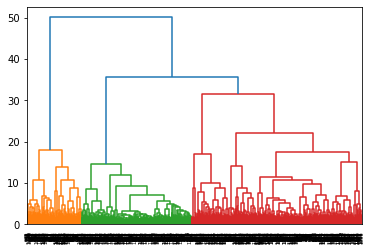

In [72]:
cap_dend = scipy.cluster.hierarchy.dendrogram(cap_linkage_matrix, get_leaves=True)

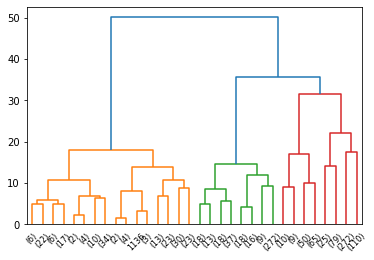

In [73]:
cap2_dend = scipy.cluster.hierarchy.dendrogram(cap_linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [74]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(capital_map.toarray())
hierarchy_full3 = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 3, 'maxclust')
print("Three cluster hierarchy analysis:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(capital_copy['link_name'], hierarchy_full3)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(capital_copy['link_name'], hierarchy_full3)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(capital_copy['link_name'], hierarchy_full3)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(capital_copy['link_name'], hierarchy_full3)))

Three cluster hierarchy analysis:
Homogeneity: 0.092
Completeness: 0.310
V-measure: 0.142
Adjusted Rand Score: 0.055


**Compare:** Three-Topic k-means clustering results: 

Homogeneity: 0.111

Completeness: 0.437

V-measure: 0.177

Adjusted Rand Score: 0.064

In [75]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(capital_map.toarray())
hierarchy_full16 = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 16, 'maxclust')
print("Three cluster hierarchy analysis:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(capital_copy['link_name'], hierarchy_full16)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(capital_copy['link_name'], hierarchy_full16)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(capital_copy['link_name'], hierarchy_full16)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(capital_copy['link_name'], hierarchy_full16)))

C:\Users\super\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Three cluster hierarchy analysis:
Homogeneity: 0.265
Completeness: 0.330
V-measure: 0.294
Adjusted Rand Score: 0.125


**Compare:** Sixteen-Topic k-means clustering analysis:

Homogeneity: 0.313

Completeness: 0.370

V-measure: 0.339

Adjusted Rand Score: 0.228

In [76]:
pandas.options.display.max_rows = 999
capital_copy['wald_predictions3'] = hierarchy_full3
capital_copy['wald_predictions16'] = hierarchy_full16
capital_copy[:100]

,index,vol_source,vol_name,link_source,link_name,paragraph_text,kmeans3_predictions,kmeans16_predictions,wald_predictions3,wald_predictions16
0,2,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,Section 1 - The Two Factors of a Commodity: U...,1,13,3,16
1,3,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,A. Elementary or Accidental Form of Value,1,13,3,12
2,4,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,1. The Two Poles of the Expression of Value: ...,1,13,3,12
3,5,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,a. The Nature and Import of this Form b. Qua...,1,13,3,16
4,6,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,3. The Equivalent Form of Value 4. The Eleme...,1,13,3,12
5,8,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,1. The Expanded Relative Form of Value 2. Th...,1,13,3,12
6,10,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,1. The Altered Character of the Form of Value...,1,13,3,12
7,12,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,Section 4 - The Fetishism of Commodities and ...,2,0,2,4
8,14,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,The wealth of those societies in which the ca...,1,13,3,10
9,15,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,"A commodity is, in the first place, an object...",2,0,2,6


**Comment:** Looking at the data table, we can see that Ward's method and k-means produced a number of divergences in prediction. Recall the silhoutte graphs we generated last exercise. Even at our "optimal" clusters of n=3 (best simple clustering scheme) and n=16 (best reasonable local maxima), the silhouttes looked pretty awful - some were severly in the negative and others diverged greatly in their weight. In other words, there were many paragraphs with sparse topics that just don't fit in, watering down the whole documents and pushing the truly optimal number of clusters (in the sense of maximizing the silhoutte score without discounting based on number of categories) way up. Ward's hierarchical method struggled more with this. It's possible that by restricting the number of words more severely we could make Ward's method more viable. I chose not to do this because such restrictions lead to key concepts like "capital" and "commodity," which are present in many, many paragraphs, falling out of the analysis. This makes it harder to interpret the topic clusters organically.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [77]:
import lucem_illud_2020
import Cython
from distutils.core import Extension, setup
#from Cython.Build import cythonize
import gensim
from gensim import corpora, models, similarities, downloader

#ext = Extension(name="hello", sources=[])
#setup(ext_modules=cythonize(ext))

In [78]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [79]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [80]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [81]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [82]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [83]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [84]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [85]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(9, 0.97372013)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [86]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [87]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(1, 0.9718367)]",0.000000,0.971837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
101,02Feb2007Kennedy10.txt,"[(2, 0.39544585), (4, 0.6000959)]",0.000000,0.000000,0.395446,0.000000,0.600096,0.000000,0.000000,0.000000,0.0,0.000000
201,04May2006Kennedy8.txt,"[(1, 0.016350714), (2, 0.54881334), (3, 0.0745...",0.000000,0.016351,0.548813,0.074593,0.163603,0.091829,0.000000,0.000000,0.0,0.097144
301,06Jun2007Kennedy1.txt,"[(4, 0.87244594), (6, 0.12572628)]",0.000000,0.000000,0.000000,0.000000,0.872446,0.000000,0.125726,0.000000,0.0,0.000000
401,08Feb2005Kennedy0.txt,"[(1, 0.17901818), (5, 0.81516755)]",0.000000,0.179018,0.000000,0.000000,0.000000,0.815168,0.000000,0.000000,0.0,0.000000
501,09Nov2005Kennedy11.txt,"[(6, 0.2068133), (7, 0.7547164)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206813,0.754716,0.0,0.000000
601,11Nov2005Kennedy6.txt,"[(6, 0.19039394), (9, 0.7852705)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190394,0.000000,0.0,0.785271
701,13Jun2006Kennedy1.txt,"[(0, 0.6015874), (3, 0.32762584), (9, 0.059930...",0.601587,0.000000,0.000000,0.327626,0.000000,0.000000,0.000000,0.000000,0.0,0.059930
801,15Dec2005Kennedy5.txt,"[(1, 0.28223425), (5, 0.7154127)]",0.000000,0.282234,0.000000,0.000000,0.000000,0.715413,0.000000,0.000000,0.0,0.000000
901,16May2007Kennedy5.txt,"[(0, 0.2320093), (5, 0.7272603)]",0.232009,0.000000,0.000000,0.000000,0.000000,0.727260,0.000000,0.000000,0.0,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [88]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.to_numpy()
ldaDFVisNames = ldaDFVisN.to_numpy()
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.973720
1,0.000000,0.971837,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.993052,0.00000,0.000000,0.000000,0.00000,0.0,0.000000
3,0.000000,0.333510,0.000000,0.175373,0.00000,0.000000,0.291693,0.19556,0.0,0.000000
4,0.128606,0.288665,0.000000,0.000000,0.00000,0.580948,0.000000,0.00000,0.0,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.991431,0.000000,0.00000,0.0,0.000000
6,0.000000,0.136222,0.000000,0.000000,0.25524,0.000000,0.000000,0.00000,0.0,0.600274
7,0.000000,0.000000,0.000000,0.967478,0.00000,0.000000,0.000000,0.00000,0.0,0.000000
8,0.000000,0.000000,0.493135,0.502294,0.00000,0.000000,0.000000,0.00000,0.0,0.000000
9,0.000000,0.000000,0.000000,0.967488,0.00000,0.000000,0.000000,0.00000,0.0,0.000000


First we can visualize as a stacked bar chart:

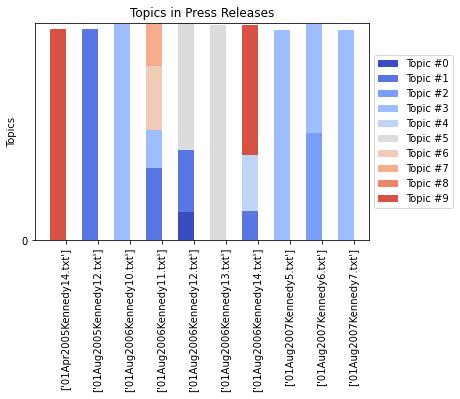

In [89]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

C:\Users\super\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


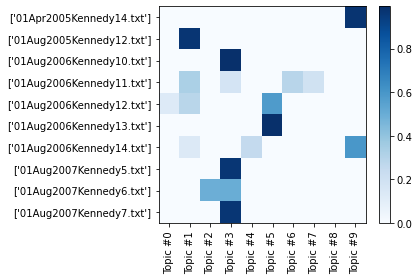

In [90]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [91]:
senlda.show_topic(1)

[('worker', 0.01545699),
 ('fund', 0.011964361),
 ('company', 0.007354159),
 ('pension', 0.005037764),
 ('retirement', 0.0046651294),
 ('asbestos', 0.0043323343),
 ('immigrant', 0.0041901553),
 ('medicare', 0.0037440818),
 ('employer', 0.0036633478),
 ('immigration', 0.0034334087)]

And if we want to make a dataFrame:

In [92]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,pension,worker,fund,loan,troop,wage,worker,fund,head,fund
1,worker,fund,worker,lender,worker,worker,wage,worker,unite,citizen
2,teacher,company,mental,rate,fund,minimum,fund,fda,fund,follow
3,woman,pension,company,tobacco,loan,fund,minimum,troop,loan,mental
4,fund,retirement,intelligence,fda,immigration,loan,immigration,immigration,agency,judge
5,head,asbestos,hear,unite,coverage,hour,head,unite,citizen,medicare
6,judge,immigrant,question,ireland,lender,head,insurance,city,worker,head
7,standard,medicare,coverage,parent,violence,aid,unite,follow,concern,intelligence
8,teach,employer,agency,association,unite,troop,hear,loan,judge,ask
9,follow,immigration,troop,company,insurance,woman,citizen,fail,intelligence,attorney


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

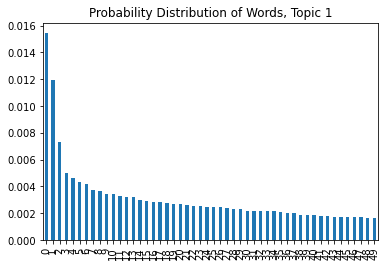

In [93]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [94]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

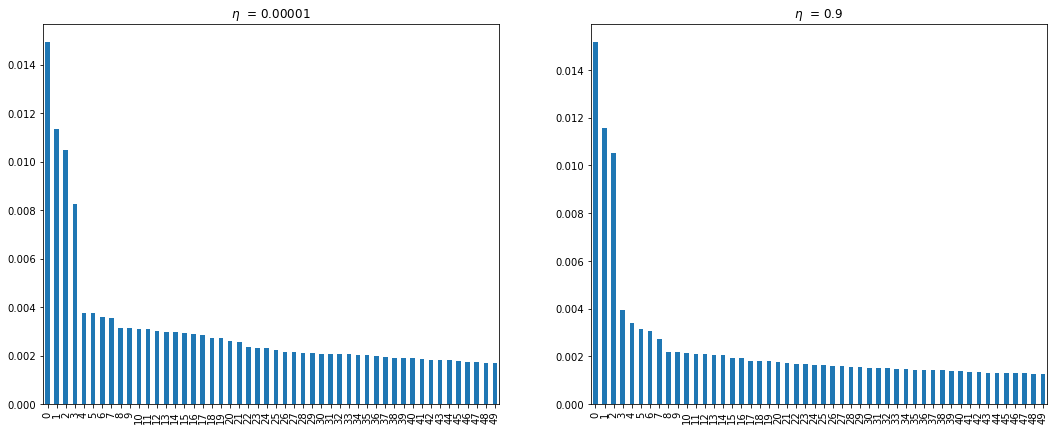

In [95]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [96]:
#Apply our functions
capital_copy['tokenized_text'] = capital_copy['paragraph_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
capital_copy['normalized_tokens'] = capital_copy['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

capital_copy['reduced_tokens'] = capital_copy['normalized_tokens'].apply(lambda x: dropMissing(x, capTFVectorizer.vocabulary_.keys()))

cap_dictionary = gensim.corpora.Dictionary(capital_copy['reduced_tokens'])
cap_corpus = [dictionary.doc2bow(text) for text in capital_copy['reduced_tokens']]

In [97]:
gensim.corpora.MmCorpus.serialize('capital.mm', cap_corpus)
cap_mm = gensim.corpora.MmCorpus('capital.mm')

In [98]:
cap_lda = gensim.models.ldamodel.LdaModel(corpus=cap_mm, id2word=dictionary, num_topics=16, alpha='auto', eta='auto')

In [99]:
cap_ldaDF = pandas.DataFrame({
        'paragraph' : capital_copy['paragraph_text'].str[:20],
        'topics' : [cap_lda[cap_dictionary.doc2bow(l)] for l in capital_copy['reduced_tokens']]
    })

In [100]:
#Dict to temporally hold the probabilities
cap_topicsProbDict = {i : [0] * len(cap_ldaDF) for i in range(cap_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(cap_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        cap_topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(cap_lda.num_topics):
    cap_ldaDF['topic_{}'.format(topicNum)] = cap_topicsProbDict[topicNum]

cap_ldaDF[1::100]

,paragraph,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
1,A. Elementary or Ac,"[(0, 0.066802956), (1, 0.06940095), (2, 0.0639...",0.066803,0.069401,0.063994,0.059862,0.059893,0.059105,0.059995,0.058266,0.060579,0.056781,0.070839,0.065221,0.059309,0.058384,0.067364,0.064204
101,"Nevertheless, the e","[(0, 0.78077936), (1, 0.016303228), (2, 0.0150...",0.780779,0.016303,0.015033,0.014062,0.014070,0.013885,0.014094,0.013687,0.014231,0.013339,0.016641,0.015321,0.013932,0.013715,0.015825,0.015082
201,Every owner of a com,"[(0, 0.010391406), (1, 0.010795536), (8, 0.853...",0.010391,0.010796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.853870,0.000000,0.011019,0.010145,0.000000,0.000000,0.010479,0.000000
301,"Finally, some one ma","[(13, 0.95160264)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.951603,0.000000,0.000000
401,Next: Chapter Four:,"[(0, 0.066802956), (1, 0.06940095), (2, 0.0639...",0.066803,0.069401,0.063994,0.059862,0.059893,0.059105,0.059995,0.058266,0.060579,0.056781,0.070839,0.065221,0.059309,0.058384,0.067364,0.064204
501,The value of labour-,"[(8, 0.9161576), (10, 0.06428684)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.916158,0.000000,0.064287,0.000000,0.000000,0.000000,0.000000,0.000000
601,19. “Where referenc,"[(0, 0.015697746), (1, 0.01630825), (2, 0.7800...",0.015698,0.016308,0.780052,0.014067,0.014074,0.013889,0.014098,0.013692,0.014235,0.013343,0.016646,0.015326,0.013937,0.013720,0.015830,0.015087
701,Although the working,"[(0, 0.57471126), (2, 0.38508847)]",0.574711,0.000000,0.385088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
801,“It is true that th,"[(12, 0.90285987)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.902860,0.000000,0.000000,0.000000
901,It must be acknowled,"[(7, 0.9455086)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.945509,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [101]:
cap_ldaDFV = cap_ldaDF[:50][['topic_%d' %x for x in range(16)]]
cap_ldaDFVisN = cap_ldaDF[:50][['paragraph']]
cap_ldaDFVis = cap_ldaDFV.to_numpy()
cap_ldaDFVisNames = cap_ldaDFVisN.to_numpy()
cap_ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
0,0.032033,0.033279,0.551174,0.028704,0.028720,0.028341,0.028768,0.027939,0.029048,0.027227,0.033968,0.031274,0.028439,0.027996,0.032302,0.030787
1,0.066803,0.069401,0.063994,0.059862,0.059893,0.059105,0.059995,0.058266,0.060579,0.056781,0.070839,0.065221,0.059309,0.058384,0.067364,0.064204
2,0.021070,0.021890,0.020185,0.703470,0.018891,0.018642,0.018923,0.018378,0.019107,0.017909,0.022343,0.020571,0.018707,0.018415,0.021247,0.020251
3,0.021070,0.021889,0.020184,0.018881,0.703487,0.018642,0.018923,0.018377,0.019107,0.017909,0.022343,0.020571,0.018706,0.018415,0.021247,0.020250
4,0.032031,0.033277,0.030684,0.028703,0.028718,0.028340,0.028767,0.027938,0.029047,0.027226,0.033966,0.031272,0.028438,0.027995,0.032300,0.551298
5,0.021069,0.021889,0.020184,0.703484,0.018890,0.018641,0.018922,0.018377,0.019106,0.017909,0.022342,0.020570,0.018706,0.018414,0.021246,0.020250
6,0.368464,0.021892,0.020187,0.018883,0.018893,0.018644,0.018925,0.018380,0.019109,0.017911,0.359512,0.020573,0.018708,0.018417,0.021250,0.020253
7,0.032035,0.033280,0.030688,0.028706,0.028721,0.028343,0.549233,0.027941,0.029050,0.027229,0.033970,0.031276,0.028441,0.027998,0.032304,0.030788
8,0.021066,0.021886,0.020181,0.018877,0.018887,0.018639,0.018919,0.018374,0.703753,0.017906,0.022339,0.020567,0.018703,0.018412,0.021243,0.020247
9,0.010394,0.010798,0.000000,0.000000,0.853729,0.000000,0.000000,0.000000,0.000000,0.000000,0.011022,0.010148,0.000000,0.000000,0.010481,0.000000


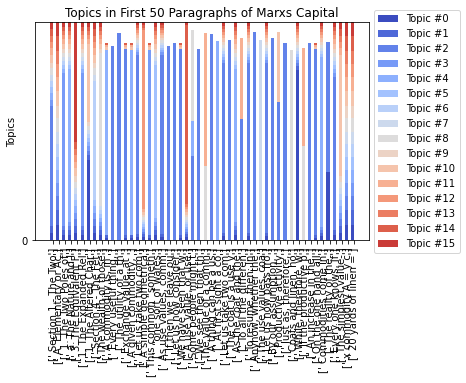

In [102]:
N = 50
ind = np.arange(N)
K = cap_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, cap_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, cap_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += cap_ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in First 50 Paragraphs of Marxs Capital')
plt.xticks(ind+width/2, cap_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.rcParams["figure.figsize"] = (12,5)
plt.show()

**Comment:** The first 50 paragraphs, which are all located within Chapter 1 (The Commodity) seem to be largely about the same thing (Topic 8.) Makes sense.

C:\Users\super\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


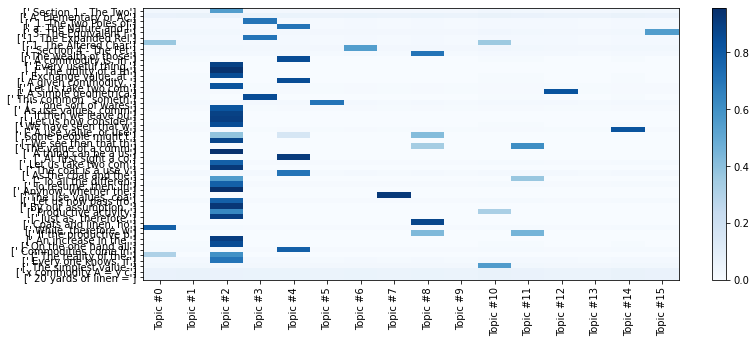

In [103]:
plt.pcolor(cap_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(cap_ldaDFVis.shape[0])+0.5, cap_ldaDFVisNames);
plt.xticks(np.arange(cap_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
#plt.tight_layout()  # fixes margins

plt.rcParams["figure.figsize"] = (12,12)
plt.show()

In [104]:
topicsDict = {}
for topicNum in range(cap_lda.num_topics):
    topicWords = [w for w, p in cap_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

cap_wordRanksDF = pandas.DataFrame(topicsDict)
cap_wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15
0,price,value,hour,hour,hour,hour,value,hour,hour,hour,capital,hour,et,hour,value,capital
1,value,hour,factory,factory,factory,factory,form,factory,factory,factory,value,factory,hour,value,hour,man
2,factory,capital,31st,man,hand,value,wage,value,agricultural,31st,production,value,value,factory,capital,class
3,form,wage,man,wage,capital,man,hour,employ,wage,night,product,production,man,employ,factory,population
4,capital,price,english,31st,man,form,production,31st,april,hand,surplus,31st,les,capital,mean,employ
5,wage,man,october,london,31st,hand,produce,age,man,age,wage,form,la,hand,man,machinery
6,production,production,employ,capital,person,wage,price,hand,31st,machinery,mean,capital,factory,mean,form,production
7,hand,surplus,england,october,operative,capital,factory,operative,trade,capital,wealth,mean,des,manufacture,production,wage
8,mean,factory,trade,april,employ,product,different,price,english,october,form,october,il,october,machinery,mean
9,man,employ,capital,english,english,price,machine,mean,employ,april,productive,wage,mean,production,hand,town


**Comment:** Looking at the above data table, becomes clear why Topic 8 dominates our first 50 paragraphs - topic 8 is about the value form, which is explicitly the subject of chapter 1. Makes sense. 

The data table is also quite revealing, though. Topics 0 and 1 have as their most frequent word "capital," while topics 2 and 8 have the most frequent word "value," and the REST of the topics take as their primary word "work." While some of the "work" topics do seem distinct, others are questionable - for instance, topic 6 vs. topic 13. This suggests to me that it could be worthwhile to mount a return to our 3-topic breakdown for earlier. Thus let us now repeat the entire above analysis with just 3 topics.

In [105]:
cap_lda3 = gensim.models.ldamodel.LdaModel(corpus=cap_mm, id2word=dictionary, num_topics=3, alpha='auto', eta='auto')

In [106]:
cap_lda3DF = pandas.DataFrame({
        'paragraph' : capital_copy['paragraph_text'].str[:20],
        'topics' : [cap_lda3[cap_dictionary.doc2bow(l)] for l in capital_copy['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
cap_topics3ProbDict = {i : [0] * len(cap_lda3DF) for i in range(cap_lda3.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(cap_lda3DF['topics']):
    for topicNum, prob in topicTuples:
        cap_topics3ProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(cap_lda3.num_topics):
    cap_lda3DF['topic_{}'.format(topicNum)] = cap_topics3ProbDict[topicNum]

cap_lda3DF[1::100]

,paragraph,topics,topic_0,topic_1,topic_2
1,A. Elementary or Ac,"[(0, 0.11454917), (1, 0.72242916), (2, 0.16302...",0.114549,0.722429,0.163022
101,"Nevertheless, the e","[(1, 0.9774589), (2, 0.01338559)]",0.000000,0.977459,0.013386
201,Every owner of a com,"[(1, 0.9789936), (2, 0.012183143)]",0.000000,0.978994,0.012183
301,"Finally, some one ma","[(1, 0.99252903)]",0.000000,0.992529,0.000000
401,Next: Chapter Four:,"[(0, 0.084991775), (1, 0.79500866), (2, 0.1199...",0.084992,0.795009,0.120000
501,The value of labour-,"[(1, 0.9930979)]",0.000000,0.993098,0.000000
601,19. “Where referenc,"[(0, 0.025490673), (1, 0.93808454), (2, 0.0364...",0.025491,0.938085,0.036425
701,Although the working,"[(1, 0.99132377)]",0.000000,0.991324,0.000000
801,“It is true that th,"[(0, 0.01086459), (1, 0.9736123), (2, 0.015523...",0.010865,0.973612,0.015523
901,It must be acknowled,"[(1, 0.9878395)]",0.000000,0.987840,0.000000


In [107]:
cap_lda3DFV = cap_lda3DF[:50][['topic_%d' %x for x in range(3)]]
cap_lda3DFVisN = cap_lda3DF[:50][['paragraph']]
cap_lda3DFVis = cap_lda3DFV.to_numpy()
cap_lda3DFVisNames = cap_lda3DFVisN.to_numpy()
cap_lda3DFV

,topic_0,topic_1,topic_2
0,0.023832,0.943195,0.032973
1,0.114549,0.722429,0.163022
2,0.033973,0.920015,0.046012
3,0.070487,0.837493,0.092020
4,0.048878,0.872568,0.078554
5,0.033643,0.920989,0.045368
6,0.020810,0.884640,0.094550
7,0.085299,0.797933,0.116768
8,0.026127,0.935679,0.038194
9,0.014714,0.965175,0.020111


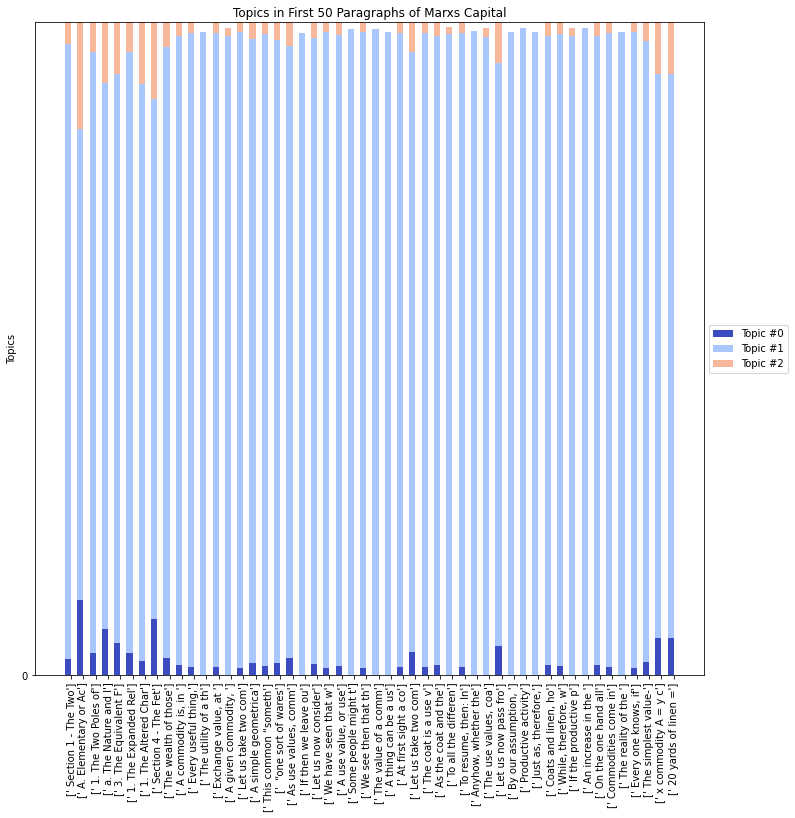

In [108]:
N = 50
ind = np.arange(N)
K = cap_lda3.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, cap_lda3DFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, cap_lda3DFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += cap_lda3DFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in First 50 Paragraphs of Marxs Capital')
plt.xticks(ind+width/2, cap_lda3DFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.rcParams["figure.figsize"] = (20,5)
plt.show()

C:\Users\super\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


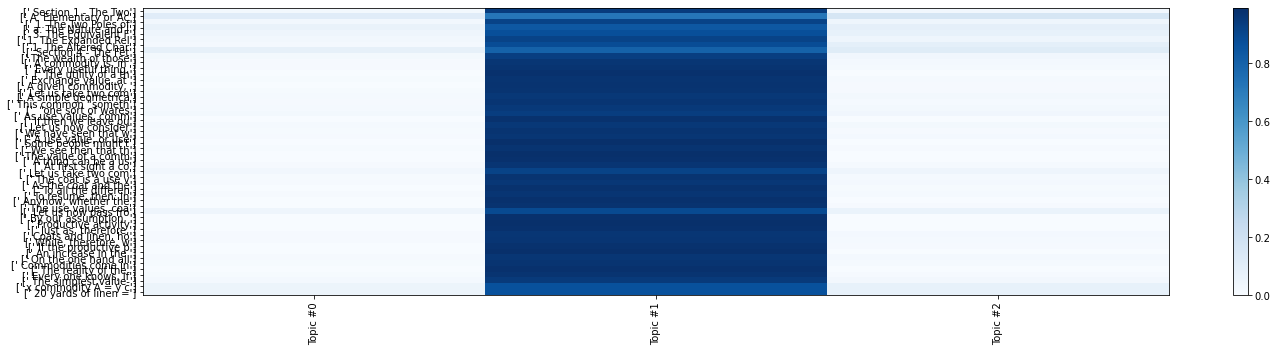

In [109]:
plt.pcolor(cap_lda3DFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(cap_lda3DFVis.shape[0])+0.5, cap_lda3DFVisNames);
plt.xticks(np.arange(cap_lda3DFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins

#plt.rcParams["figure.figsize"] = (12,12)
plt.show()

**Comment:** Alas, the three topic model did not result in any clearer mapping of paragraphs to topics - in fact, it actually substantially increased the level of entropy. One recalls why we included the 16 topic cluster in the first place now.

Let us end this exercise by varying alpha eta, using our 16 topic model.

In [110]:
cap_lda1 = gensim.models.ldamodel.LdaModel(corpus=cap_mm, id2word=dictionary, num_topics=16, eta = 0.00001)
cap_lda2 = gensim.models.ldamodel.LdaModel(corpus=cap_mm, id2word=dictionary, num_topics=16, eta = 0.9)

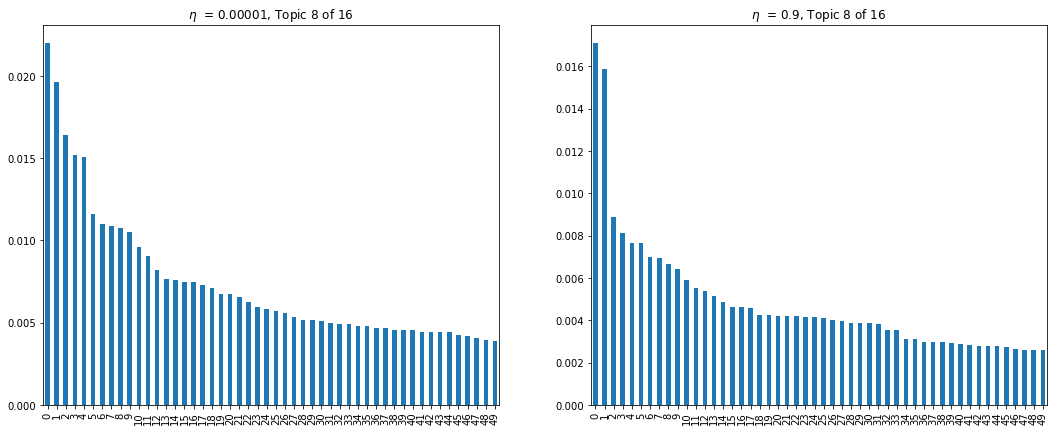

In [111]:
topic11_df = pandas.DataFrame(cap_lda1.show_topic(8, topn=50))
topic21_df = pandas.DataFrame(cap_lda2.show_topic(8, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001, Topic 8 of 16')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9, Topic 8 of 16')
plt.show()

In [112]:
cap_lda1 = gensim.models.ldamodel.LdaModel(corpus=cap_mm, id2word=dictionary, num_topics=16, alpha = 0.00001)
cap_lda2 = gensim.models.ldamodel.LdaModel(corpus=cap_mm, id2word=dictionary, num_topics=16, alpha = 0.9)

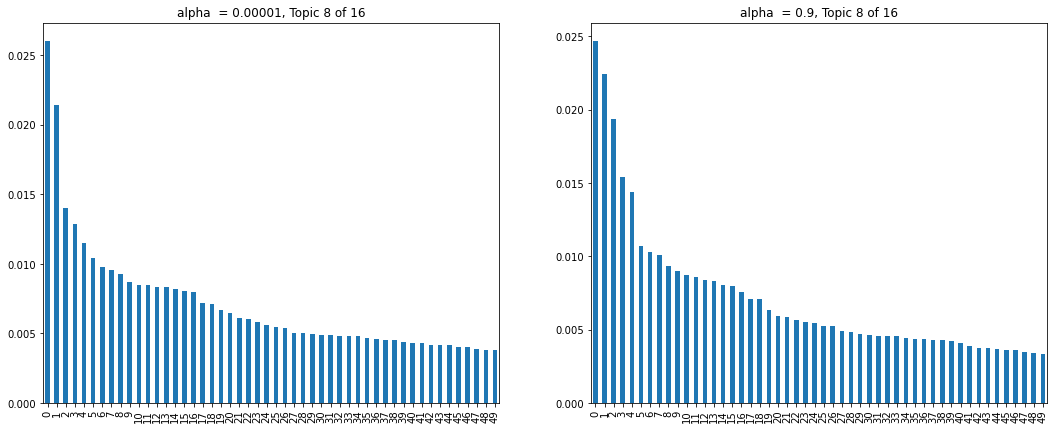

In [113]:
topic11_df = pandas.DataFrame(cap_lda1.show_topic(8, topn=50))
topic21_df = pandas.DataFrame(cap_lda2.show_topic(8, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = 'alpha  = 0.00001, Topic 8 of 16')
topic21_df.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.9, Topic 8 of 16')
plt.show()

**Comment:** Varying both eta and alpha had little effect on the outcome for Topic 8. This is likely due to how strongly idiosyncratic Topic 8 paragraphs are, as we saw in the bar graph models of Chapter 1 (a key hotbed of Topic 8 paragraphs in the whole corpus.) 

Recall also the silhoutte graphs from Exercise 1. When I varied the vectorizing parameters substantially, there was relatively little effect on the centering and optimality of clusters. I think this may be because most of the words on the margins are relatively fluid across topics, whereas the larger and more natural topic clusters have top words which are relatively stable across parameters.

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [114]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [115]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP/'

In [ ]:
import zipfile
import pandas as pd

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [ ]:
dool = soap_df['Tokenized Texts'][9]

In [ ]:
' '.join(dool[0:1500])

In [ ]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
i = 0

In [ ]:
all_texts = []

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

In [ ]:
list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [ ]:
coha_genres = {}
coha_years = {}

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [ ]:
coha_genres.keys()

In [ ]:
coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [ ]:
import collections

In [ ]:
years = []
year_lens = []

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [ ]:
years[0], years[-1]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [ ]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
 ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

**Comment:** The corpus I'm using for this HW, namely Volume 35 of the larger Marx-Engels Collected Works (MECW) on which I'm basing my final project, is not time annotated (although the MECW as a whole is.) However, just for fun, I'm going to use dynamic topic modelling on Marx's Capital here with a different objective in mind: what if we treat the text as an evolving discourse in itself, i.e. each chapter (and each subsequent paragraph by extension) as offering an evolution over older paragraphs? Let's find out. Here, I'm going to treat each subsequent row as another "year" in the analysis, meaning that the text encompasses 2,830 "years."

Unfortunately, after playing around, it seems that my computer cannot handle 2,800 "years" - so we will just sample 100 rows from the dataframe.

In [116]:
capital_yrs = capital_copy
capital_yrs['year'] = capital_yrs['link_name']
capital_yrs['time_slice'] = capital_yrs['link_name']
ch = 'Chapter I Commodities'
time = 0

for y in range(len(capital_yrs)):
    capital_yrs['year'][y] = y
    if capital_yrs['link_name'][y]==ch:
        capital_yrs['time_slice'][y] = time
    else:
        time += 1
        ch = capital_yrs['link_name'][y]
        capital_yrs['time_slice'][y] = time
    
capital_yrs

C:\Users\super\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\super\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\super\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,vol_source,vol_name,link_source,link_name,paragraph_text,kmeans3_predictions,kmeans16_predictions,wald_predictions3,wald_predictions16,tokenized_text,normalized_tokens,reduced_tokens,year,time_slice
0,2,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,Section 1 - The Two Factors of a Commodity: U...,1,13,3,16,"[Section, 1, The, Two, Factors, of, a, Commodi...","[section, factor, commodity, use, value, value...","[section, commodity, use, value, value, sectio...",0,0
1,3,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,A. Elementary or Accidental Form of Value,1,13,3,12,"[A., Elementary, or, Accidental, Form, of, Value]","[a., elementary, accidental, form, value]","[form, value]",1,0
2,4,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,1. The Two Poles of the Expression of Value: ...,1,13,3,12,"[1, The, Two, Poles, of, the, Expression, of, ...","[pole, expression, value, relative, form, equi...","[expression, value, relative, form, equivalent...",2,0
3,5,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,a. The Nature and Import of this Form b. Qua...,1,13,3,16,"[a., The, Nature, and, Import, of, this, Form,...","[a., nature, import, form, b., quantitative, d...","[nature, form, relative, value]",3,0
4,6,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,3. The Equivalent Form of Value 4. The Eleme...,1,13,3,12,"[3, The, Equivalent, Form, of, Value, 4, The, ...","[equivalent, form, value, elementary, form, va...","[equivalent, form, value, form, value, consider]",4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,19,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch33.html,Chapter XXXIII The Modern Theory of Colonisation,"5. E. G. Wakefield: “England and America,” vol...",2,0,2,4,"[5, E., G., Wakefield, England, and, America, ...","[e., g., wakefield, england, america, vol.ii, ...","[wakefield, england, america]",2825,32
2826,24,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch33.html,Chapter XXXIII The Modern Theory of Colonisation,"10. “Land, to be an element of colonization, m...",2,12,2,6,"[10, Land, to, be, an, element, of, colonizati...","[land, element, colonization, waste, public, p...","[land, waste, public, property, private, prope...",2826,32
2827,30,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch33.html,Chapter XXXIII The Modern Theory of Colonisation,"16. Merivale, l.c., Vol.II, pp.235-314 passim....",2,10,2,5,"[16, Merivale, l.c, Vol, II, pp.235, 314, pass...","[merivale, l.c, vol, ii, pp.235, passim, mild,...","[vol, ii, free, trade, economist, say, dans, l...",2827,32
2828,34,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch33.html,Chapter XXXIII The Modern Theory of Colonisation,"20. “C’est, ajoutez-vous, grâce � l’appropriat...",2,10,2,5,"[20, C’est, ajoutez, vous, grâce, �, l’appropr...","[c’est, ajoutez, vous, grâce, �, l’appropriati...","[du, et, des, que, qui, que, et, se, du, se, d...",2828,32


In [117]:
capital_sample = capital_yrs.sample(n=100).sort_index()
capital_sample

,index,vol_source,vol_name,link_source,link_name,paragraph_text,kmeans3_predictions,kmeans16_predictions,wald_predictions3,wald_predictions16,tokenized_text,normalized_tokens,reduced_tokens,year,time_slice
4,6,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,3. The Equivalent Form of Value 4. The Eleme...,1,13,3,12,"[3, The, Equivalent, Form, of, Value, 4, The, ...","[equivalent, form, value, elementary, form, va...","[equivalent, form, value, form, value, consider]",4,0
18,24,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,"As use values, commodities are, above all, of...",1,15,3,10,"[As, use, values, commodities, are, above, all...","[use, value, commodity, different, quality, ex...","[use, value, commodity, different, exchange, v...",18,0
42,50,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,An increase in the quantity of use values is ...,1,15,3,16,"[An, increase, in, the, quantity, of, use, val...","[increase, quantity, use, value, increase, mat...","[increase, quantity, use, value, increase, mat...",42,0
55,65,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,(a.) The nature and import of this form,2,13,3,12,"[a., The, nature, and, import, of, this, form]","[a., nature, import, form]","[nature, form]",55,0
84,96,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,The body of the commodity that serves as the ...,1,1,3,15,"[The, body, of, the, commodity, that, serves, ...","[body, commodity, serve, equivalent, figure, m...","[body, commodity, serve, equivalent, human, ti...",84,0
134,148,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,The difficulty in forming a concept of the mo...,1,13,3,12,"[The, difficulty, in, forming, a, concept, of,...","[difficulty, form, concept, money, form, consi...","[form, money, form, universal, equivalent, for...",134,0
147,163,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,For an example of labour in common or directl...,2,5,3,10,"[For, an, example, of, labour, in, common, or,...","[example, labour, common, directly, associate,...","[example, common, directly, form, history, clo...",147,0
160,176,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch01.html,Chapter I Commodities,4. “The natural worth of anything consists in...,1,15,3,10,"[4, The, natural, worth, of, anything, consist...","[natural, worth, consist, fitness, supply, nec...","[natural, worth, supply, necessity, serve, hum...",160,0
205,10,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch02.html,Chapter II. Exchange,"In the direct barter of products, each commodi...",1,13,3,12,"[In, the, direct, barter, of, products, each, ...","[direct, barter, product, commodity, directly,...","[direct, product, commodity, directly, mean, e...",205,1
257,34,http://hiaw.org/defcon6/works/cw/volume35/inde...,Volume 35,http://hiaw.org/defcon6/works/1867-c1/ch03.html,"Chapter III. Money, or the Circulation of Comm...","The comprehension of this change of form is, a...",1,13,3,12,"[The, comprehension, of, this, change, of, for...","[comprehension, change, form, rule, imperfect,...","[change, form, rule, cause, apart, value, chan...",257,2


**Comment:** Let's treat every chapter as a time slice. This means we'll have 33 time slices. Let's count how many docs per chapter, and then do the analysis!

In [118]:
docs_per_time_slice = [0] * 33
for time in capital_sample['time_slice']:
    docs_per_time_slice[time] += 1

docs_per_time_slice

[8,
 1,
 3,
 3,
 2,
 0,
 3,
 3,
 2,
 20,
 1,
 2,
 0,
 5,
 18,
 1,
 1,
 0,
 0,
 1,
 3,
 1,
 4,
 4,
 9,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 0]

In [119]:
from gensim.models import ldaseqmodel
yrs_dictionary = gensim.corpora.Dictionary(capital_sample['reduced_tokens'])
yrs_corpus = [yrs_dictionary.doc2bow(text) for text in capital_sample['reduced_tokens']]

In [120]:
yrs_ldaseq = ldaseqmodel.LdaSeqModel(corpus=yrs_corpus, id2word=yrs_dictionary, time_slice=docs_per_time_slice, num_topics=16)

C:\Users\super\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [125]:
yrs_ldaseq.print_topics(time=0)[0]

[('surplus', 0.11636853485777064),
 ('value', 0.09745794602374522),
 ('necessary', 0.04730492353443227),
 ('capital', 0.04142299720311757),
 ('day', 0.03971653331369225),
 ('work', 0.03468994902762643),
 ('hand', 0.02808278970359693),
 ('additional', 0.02225617943634083),
 ('quantity', 0.021996346485631854),
 ('power', 0.021643459722361886),
 ('ratio', 0.019829574726738724),
 ('reference', 0.018501689869963485),
 ('section', 0.01807848298331227),
 ('follow', 0.017932780523315976),
 ('portion', 0.013498227746877638),
 ('variable', 0.013376077481756617),
 ('form', 0.012062052447363782),
 ('consider', 0.004546443854195297),
 ('time', 0.004396805607615832),
 ('high', 0.004134481543890915)]

In [126]:
yrs_ldaseq.print_topic_times(0)

[[('surplus', 0.11636853485777064),
  ('value', 0.09745794602374522),
  ('necessary', 0.04730492353443227),
  ('capital', 0.04142299720311757),
  ('day', 0.03971653331369225),
  ('work', 0.03468994902762643),
  ('hand', 0.02808278970359693),
  ('additional', 0.02225617943634083),
  ('quantity', 0.021996346485631854),
  ('power', 0.021643459722361886),
  ('ratio', 0.019829574726738724),
  ('reference', 0.018501689869963485),
  ('section', 0.01807848298331227),
  ('follow', 0.017932780523315976),
  ('portion', 0.013498227746877638),
  ('variable', 0.013376077481756617),
  ('form', 0.012062052447363782),
  ('consider', 0.004546443854195297),
  ('time', 0.004396805607615832),
  ('high', 0.004134481543890915)],
 [('surplus', 0.11666055102256452),
  ('value', 0.09768477404110562),
  ('necessary', 0.04738089416984601),
  ('capital', 0.04148405886153711),
  ('day', 0.03977347549959054),
  ('work', 0.034734801855725625),
  ('hand', 0.028113503353389392),
  ('additional', 0.022275107234951144),


In [144]:
yrs_ldaseq.print_topics(time=0)[5]

[('commodity', 0.07511987195687411),
 ('total', 0.04726209770686608),
 ('gold', 0.03725665382485007),
 ('la', 0.028459022133996374),
 ('price', 0.025595311696967226),
 ('value', 0.02473180979298929),
 ('money', 0.024243112583789056),
 ('form', 0.02401101902823405),
 ('certain', 0.023499313632300775),
 ('fact', 0.018261050792978344),
 ('political', 0.018122532990727837),
 ('qui', 0.0172942709513988),
 ('des', 0.01597153231994306),
 ('silver', 0.01596434679879656),
 ('du', 0.015961046407854538),
 ('view', 0.015559155471058846),
 ('adam', 0.01543355470997969),
 ('smith', 0.015390956934751922),
 ('et', 0.015387511709301551),
 ('decrease', 0.014660698920066871)]

In [143]:
yrs_ldaseq.print_topic_times(5)

[[('commodity', 0.07511987195687411),
  ('total', 0.04726209770686608),
  ('gold', 0.03725665382485007),
  ('la', 0.028459022133996374),
  ('price', 0.025595311696967226),
  ('value', 0.02473180979298929),
  ('money', 0.024243112583789056),
  ('form', 0.02401101902823405),
  ('certain', 0.023499313632300775),
  ('fact', 0.018261050792978344),
  ('political', 0.018122532990727837),
  ('qui', 0.0172942709513988),
  ('des', 0.01597153231994306),
  ('silver', 0.01596434679879656),
  ('du', 0.015961046407854538),
  ('view', 0.015559155471058846),
  ('adam', 0.01543355470997969),
  ('smith', 0.015390956934751922),
  ('et', 0.015387511709301551),
  ('decrease', 0.014660698920066871)],
 [('commodity', 0.0752857003246383),
  ('total', 0.04734661146142788),
  ('gold', 0.03730809077171445),
  ('la', 0.028497358768654203),
  ('price', 0.02562284605064039),
  ('value', 0.02476024870547155),
  ('money', 0.02426515411022198),
  ('form', 0.024030129351333307),
  ('certain', 0.023523755030465016),
  ('

**Comment:** Topic 5's change over time (or lack thereof) in my mind speaks as to the weakness of this appraoch: despite Marx only quoting Adam Smith and writing in French in very localized parts of the text, we don't see much change in the weights of Smith or French words within the topic over time. I speculate that this could be improved if I had the computational power to analyze the entire text rather than 100 random paragraphs. 

Topic 0 is a bit more interesting. We see that "capital" rises in relative weight and overtakes several other words within the topic. This is somewhat interesting considering that the overall topic is clearly about surplus value: it shows that Marx goes from thinking about surplus value in the context of the commodity in earlier chapters to thinking later about how capital can produce surplus value. 

Perhaps, on the other hand, the relative lack of change in this text is actually mild evidence that the topics are in fact distributed somewhat evenly over chapters ("time slices.") This result would be somewhat surprising if so.